# Setup

## Import Libraries and Pretrained Model

In [1]:
%matplotlib inline
import torch, torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from warnings import warn

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
vgg = models.vgg19(pretrained=True).features  
# VGG19 have only 16 Convolutional Layers, which makes it simplier to use for transfer learning

for param in vgg.parameters():
  param.requires_grad_(False)

vgg.to(device)

## Configuration

In [4]:
IMG_CONFIG = {
    'max_size':   400,                    # Max size of output image
    'std':        [0.5, 0.5, 0.5],        # Standard Deviation for each image channel - leave if you're not sure, how to tune it
    'mean':       [0.5, 0.5, 0.5],        # Mean for each image channel - leave if you're not sure, how to tune it
}

IMAGES = {
    'content':  'kitten.jpg',             # Image to convert
    'style':    'hopperhill.jpg'          # Image with desired style
}

TRAIN_CONFIG = {
    'epochs':             3000,         # Number of iterations/epochs
    'learn_rate':         2e-3,         # Learning Rate
    'content_weight':     1,
    'style_weight':       1e4,    
}

show_every = 1000                 # Show information about learning progress every <show_every> epochs (Set 0 to disable)
capture_every = 0                 # Capture Image with current effects every <capture_every> epochs (Set 0 to disable)

DOWNLOAD = {
    'image':      True,         # set True if you want to download automaticly picture with last result
    'movie':      False,        # set True if you want to download sequence of images as movie (works only if capture_every > 0)
    'output_dir': "/content"    # Directory where result will be saved
}


assert IMG_CONFIG['max_size'] > 0, "Max Size of Image must be positive number > 0"

assert TRAIN_CONFIG['epochs'] > 0, "Number of epochs must be positive number > 0"

assert TRAIN_CONFIG['epochs'] >= show_every
assert TRAIN_CONFIG['epochs'] >= capture_every
assert ((TRAIN_CONFIG['learn_rate'] < 1) and (TRAIN_CONFIG['learn_rate'] > 0)), "Not allowed value of learning rate"

if show_every < 1:
  warn("Showing Results during training - Disabled")

if capture_every < 1:
  warn("Checkpoint Image Saving - Disabled")
  warn("Download as Movie - Unavailable")


IMG_CONFIG['max_size'] = int(IMG_CONFIG['max_size'])

TRAIN_CONFIG['epochs'] = int(TRAIN_CONFIG['epochs'])

show_every = int(show_every)
capture_every = int(capture_every)

## Helper Functions

In [6]:
def load_image(img_path, max_size=IMG_CONFIG['max_size'], shape=None):
  """
  Image preparation for training
  :param img_path: path to image
  :param max_size: max allowed size of image (dimension) - Loaded Images will be resized to that
  :param shape: for setting your own dimensions of output image(tensor)
  :return: resized image as Tensor
  :rtype: Tensor
  """
  image = Image.open(img_path).convert('RGB')
  if max(image.size) > max_size:
    size = max_size
    warn("Image size of {} exceeds max size of image - Resized to max size available".format(img_path))
  else:
    size = max(image.size)
  
  if shape is not None:
    size = shape


  transform = transforms.Compose([
                      transforms.Resize(size),
                      transforms.ToTensor(),
                      transforms.Normalize(IMG_CONFIG['mean'],
                                           IMG_CONFIG['std'])
  ])
  image = transform(image).unsqueeze(0)

  return image

In [7]:
def img_convert(tensor):
  """
  Converts Tensor with Image to format that can be displayable
  :param tensor: tensor with Image
  :return: Image as numpy array
  """
  image = tensor.cpu().clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1, 2, 0)
  image = image * np.array(IMG_CONFIG['mean']) + np.array(IMG_CONFIG['std'])
  image = image.clip(0, 1)

  return image

In [8]:
def get_features(image, model):
  """
  Getter for image features from convolutional layers of given model
  :param image: Tensor with image to process
  :param model: Trained CNN model (e.g VGG19)
  :return: Feature Map of Image at given layer
  """
  layers = {
      '0': 'conv1_1',
      '5': 'conv2_1',
      '10': 'conv3_1',
      '19': 'conv4_1',
      '21': 'conv4_2',
      '28': 'conv5_1'} # Some of convolutional layers here were skipped

  features = {}

  for name, layer in model._modules.items():
    image = layer(image)

    if name in layers:
      features[layers[name]] = image
  return features

In [9]:
def calc_MSE(current, target):
  """
  Calculates Mean Square Error
  :param current: Tensor with Actual Value
  :param target: Tensor with Estimated Value
  :return: Calculated Mean Square Error
  :rtype: Tensor
  """
  return torch.mean((current - target) ** 2)

In [10]:
def gram_matrix(tensor):
  """
  Calculates Gram Matrix.
  :param: tensor - tensor (input matrix) to calculate Gram Matrix from
  :return: gram matrix tensor
  :rtype: Tensor
  """
  _, d, h, w = tensor.size()  #_ - batch size(not used) , d - image depth, h - image height, w - width
  
  tensor = tensor.view(d, h * w)
  gram = torch.mm(tensor, tensor.t())
  return gram

# Image Loading and Display

In [11]:
content = load_image(IMAGES['content']).to(device)
# style = load_image(IMAGES['style']).to(device)
style = load_image(IMAGES['style'], shape=content.shape[-2:]).to(device) # Fit Image to match size of content

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Image size of kitten.jpg exceeds max size of image - Resized to max size available
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Image size of hopperhill.jpg exceeds max size of image - Resized to max size available
  """


(-0.5, 599.5, 399.5, -0.5)

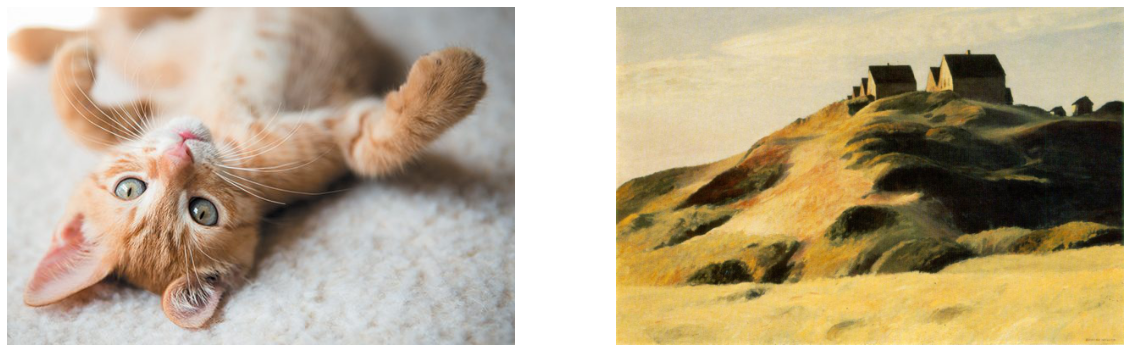

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_convert(content))
ax1.axis("off")

ax2.imshow(img_convert(style))
ax2.axis("off")

# Training

In [13]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [14]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

style_weights = {
    'conv1_1':  1.1,
    'conv2_1':  0.75,
    'conv3_1':  0.20,
    'conv4_1':  0.2,
    'conv5_1':  0.2
} # early layers have better feature maps (styles)


target = content.clone().requires_grad_(True).to(device)

height, width, channels = img_convert(target).shape

images_saved = np.empty(shape=(capture_every, height, width, channels))

In [15]:
optimizer = optim.Adam([target], lr=TRAIN_CONFIG['learn_rate'])
# There's no point of using steping learning rate, weight decay or better optimizer (like SGD) in this case

Iteration: 1000
Content Loss: 2.496226, Style Loss: 0.093732
Total Loss: 939.817626953125


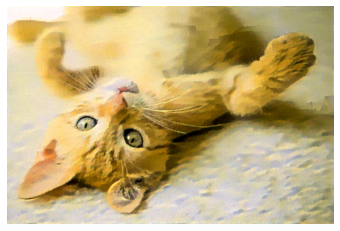

Iteration: 2000
Content Loss: 2.585645, Style Loss: 0.049252
Total Loss: 495.1087341308594


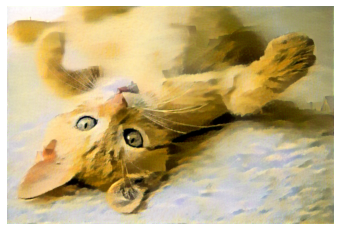

Iteration: 3000
Content Loss: 2.638915, Style Loss: 0.025256
Total Loss: 255.19735717773438


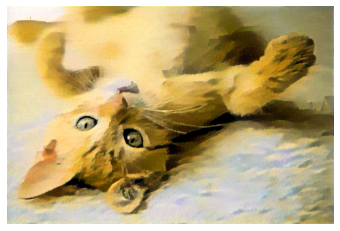

In [16]:
for iter in range(1, TRAIN_CONFIG['epochs'] + 1):
  target_features = get_features(target, vgg)
  content_loss = calc_MSE(target_features['conv4_2'], content_features['conv4_2'])

  style_loss = 0

  for layer in style_weights:
    target_feature = target_features[layer]

    target_gram = gram_matrix(target_feature)
    style_gram = style_grams[layer]

    _, d, h, w = target_feature.shape

    layer_style_loss = style_weights[layer] * calc_MSE(target_gram, style_gram)
    style_loss += layer_style_loss / (d * h * w)

  total_loss = TRAIN_CONFIG['content_weight'] * content_loss + TRAIN_CONFIG['style_weight'] * style_loss

  optimizer.zero_grad()
  
  total_loss.backward()
  optimizer.step()

  if (show_every > 0) and (iter % show_every == 0):
    print("Iteration: {}".format(iter))
    print("Content Loss: {:.6f}, Style Loss: {:.6f}".format(content_loss, style_loss))
    print('Total Loss:', total_loss.item())
    
    plt.imshow(img_convert(target))
    plt.axis("off")
    plt.show()
  
  if (capture_every > 0) and (iter % capture_every == 0):
    images_saved[int(iter / capture_every)] = img_convert(target)

# Results - Display and Saving

## Display Results

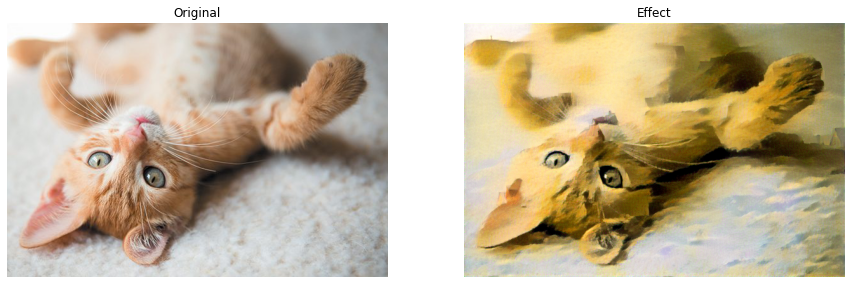

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
ax1.imshow(img_convert(content))
ax1.axis("off")
ax1.title.set_text("Original")

ax2.imshow(img_convert(target))
ax2.axis("off")
ax2.title.set_text("Effect")

## Save Results

In [18]:
if DOWNLOAD['image'] or DOWNLOAD['movie']:
  from google.colab import files
  import os
  # from torchvision.utils import save_image

  if DOWNLOAD['image']:
    filename = os.path.join(DOWNLOAD['output_dir'], "result.png")

    img = img_convert(target)
    height, width, _ = img.shape

    img = img * 255
    img = np.array(img, dtype= np.uint8)
    img = Image.fromarray(img, 'RGB')
    img.save(filename)

    # img = target[0]
    # save_image(img, filename) # kept, cause of pretty effect

    
    files.download(filename)
  
  if DOWNLOAD['movie'] and (capture_every > 0):
    import cv2

    filename = os.path.join(DOWNLOAD['output_dir'], "result.mp4")

    frame_height, frame_width, _ = im_convert(target).shape

    vid = cv2.VideoWriter(filename, cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height))

    for i in range(int(epochs / capture_every)):
      img = images_saved[i]

      img = img * 255
      img = np.array(img, dtype= np.uint8)
      cv2.cvtColor(img, cv2.COLOR_BAYER_BG2RGB)
      vid.write(img)
    
    vid.release()
    files.download(filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>